![](/images/blog/autochess.png)

The Dota 2 custom map "Dota Auto Chess" is taking the gaming world by storm. Auto Chess is almost like a card game in which players attempt to improve their hand round after round while their "chesses" (cards) battle the other players in the game automatically. In this post, we'll explore the potential of [latent Dirichlet allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) to model strategies (specific combinations of cards that are often played together) as "topics". We will then try to visualize the evolution of Auto Chess "hands" over the course of individual games in terms of their topics using [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding). These kinds of visualizations might help us learn how to more effectively evolve our strategies.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gilgi/gilgi.github.com/blob/src/posts/autochess.ipynb)

<!-- TEASER_END -->

Update: the Varena Auto Chess API used in this notebook no longer works, but hopefully the analysis and visualization approach still makes for an interesting read!

In [0]:
import json
import urllib

import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt
import pandas as pd
from ipywidgets import interact
from IPython.display import display
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

First, we'll paste in and load some JSON containing information about all the chesses (the cards of Auto Chess). If you're following along you can find the `chesses.json` file I used [here](/listings/chesses.json.html).

In [0]:
chesses = json.load('chesses.json')
chess_ids = sorted(chesses.keys())
races = set([r for chess in chesses.values()
             for r in chess['race'].split(', ')])
classes = set([chess['class'] for chess in chesses.values()])

We'll need some classes to interface with the [Varena Auto Chess](https://autochess.varena.com/) API. I'll use Build to refer to the sequence of hands (sets of cards) used by a single player over the course of one entire game. Each Match involves 8 Builds (one per player).

In [0]:
class Build(object):
    base_url = 'https://autochess.varena.com/api/autochess/' \
        'match/%s/detail/?player_id=%s'
    
    def __init__(self, match_key, player_id):
        self.data = json.loads(urllib.urlopen(
            self.base_url % (match_key, player_id)).read())['data']
    
    def as_sparse(self):
        val, row, col = [], [], []
        for t, board in self.data[0].items():
            for chess in board:
                row.append(int(t))
                col.append((chess['level']-1)*len(chesses) +
                           chess_ids.index(chess['chess']))
                val.append(1)
        coo = sparse.coo_matrix((val, (row, col)),
                                shape=(max(row)+1, 3*len(chesses)))
        coo.sum_duplicates()
        return coo

In [0]:
class Match(object):
    base_url = 'https://autochess.varena.com/api/autochess/match/%s/info/'
    
    def __init__(self, match_key):
        self.match_key = match_key
        self.data = json.loads(urllib.urlopen(
            self.base_url % match_key).read())['data']
        self.players, _ = zip(*sorted(
            [(k, v['rank']) for k, v in self.data['final_results'].items()],
            key=lambda x: x[1]))
    
    def rank(self, player_id):
        return self.players.index(player_id) + 1
    
    def build(self, player_id):
        return Build(self.match_key, player_id)

In [0]:
class Player(object):
    base_url = 'https://autochess.varena.com/api/autochess/player/%s/overview/'
    matches_url = 'https://autochess.varena.com/api/autochess/' \
        'player/%s/matches/?limit=%s&offset=%s'
    
    def __init__(self, player_id):
        self.player_id = player_id
        self.data = json.loads(urllib.urlopen(
            self.base_url % player_id).read())['data']
    
    def level(self):
        return self.data['current_level']
    
    def recent_matches(self, limit=20):
        return [Match(match.keys()[0])
                for match in self.data['lineup_20'][-limit:]]
    
    def matches(self, limit, offset):
        data = json.loads(urllib.urlopen(
            self.matches_url % (self.player_id, limit, offset)).read())['data']
        return [Match(match.keys()[0]) for match in data]

Get a player, check "level" (e.g., knight 4):

In [0]:
p = Player('30545806')

In [0]:
p.level()

13

Check what rank I got in the last match I played:

In [0]:
p.recent_matches(limit=1)[0].rank(p.player_id)

2

Alternative match accessor that allows getting older matches:

In [0]:
p.matches(limit=1, offset=2)[0].rank(p.player_id)

5

Get my build from my most recent match in a sparse matrix format. Each row is a round, each column represents a chess and level (number of stars on the chess). Value is the number of that chess that I have on the board at that round.

In [0]:
p.recent_matches(limit=1)[0].build(p.player_id).as_sparse()

<39x186 sparse matrix of type '<type 'numpy.int64'>'
	with 264 stored elements in COOrdinate format>

Stack my builds from my last 20 games, keeping a parallel vectors storing the round number and eventual rank:

In [0]:
recent_matches = p.recent_matches()

In [0]:
matches_sparse_list = [m.build(p.player_id).as_sparse() for m in recent_matches]
round_list = [np.arange(s.shape[0]) for s in matches_sparse_list]
rank_list = [np.tile(m.rank(p.player_id), s.shape[0])
             for m, s in zip(recent_matches, matches_sparse_list)]
builds = sparse.vstack(matches_sparse_list)
rounds = np.concatenate(round_list)
ranks = np.concatenate(rank_list)

Get the level of my courier at every round of every build:

In [0]:
levels = builds.tocsr().sum(axis=1).A1

Next, we will perform LDA on the builds. Traditionally, LDA is used to model text documents as being composed of words whose frequencies are associated with particular topics. For example, if a document's topic is "sports", then we expect it to contain a relatively high frequency of sports-related words. The analogy we're relying on here is that strategies of Auto Chess are like the topics of a document - if you're playing a particular strategy, your hand is likely to contain specific cards that are associated with that strategy. We will start out fitting a model with 5 topics, but with more data we might try to increse this since there are probably more than 5 distinct viable strategies in Auto Chess.

In [0]:
lda = LatentDirichletAllocation(n_components=5)
topics = lda.fit_transform(builds)

Under the LDA model, each document (hand, or one round of a build) recieves a weight for each of the possible topics. Specifically, `topics` is now a matrix whose rows correspond to hands and whose 5 columns correspond to the 5 topics fitted by the LDA model. In order to visualize the topic assignments in two dimensions, we will apply t-SNE:

In [0]:
topics_tsne = TSNE(n_components=2).fit_transform(topics)

Now that each hand is represented as a two-dimensional data point, we can plot a dot for each hand, coloring by courier level, round number, and eventual rank:

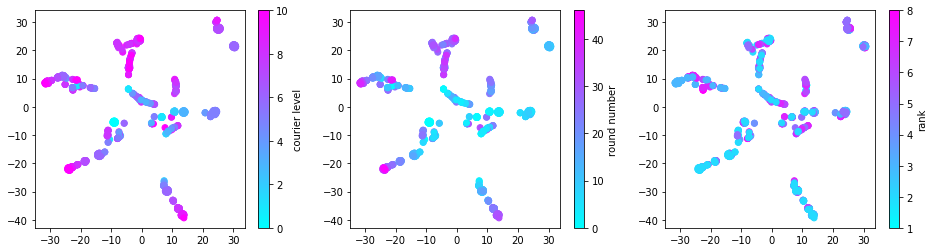

In [0]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
s1 = ax1.scatter(topics_tsne[:, 0], topics_tsne[:, 1], c=levels, cmap='cool')
plt.colorbar(mappable=s1, label='courier level', ax=ax1)
s2 = ax2.scatter(topics_tsne[:, 0], topics_tsne[:, 1], c=rounds, cmap='cool')
plt.colorbar(mappable=s2, label='round number', ax=ax2)
s3 = ax3.scatter(topics_tsne[:, 0], topics_tsne[:, 1], c=ranks, cmap='cool')
_ = plt.colorbar(mappable=s3, label='rank', ax=ax3)

From the middle plot, we can see that these dots fall on trajectories that start near the middle of the plot at the beginning of the game (low round numbers) and gradually move towards the edges. This makes sense because we'd guess that late-game hands are more specialized than early-game hands. From the right hand plot, we can also see that some trajectories were more successful than others. Next, we'll look deeper into understanding what might distinguish these trajectories.

We will need a function to get information for a specific build (one row of the `builds` matrix). We will want to keep track of the race and class of each chess, and maybe quantify the total number of chesses that belong to each race/class. This is because the strategies in Auto Chess usually revolve around putting together a hand that focuses on a small number of races/classes.

In [0]:
def build_to_df(sparse_row):
    coo = sparse_row.tocoo()
    df = pd.DataFrame({
        'chess': [chesses[chess_ids[idx % len(chesses)]]['english_name']
                  for idx in coo.col],
        'stars': [(idx / len(chesses)) + 1 for idx in coo.col],
        'n': coo.data,
        'race': [chesses[chess_ids[idx % len(chesses)]]['race']
                 for idx in coo.col],
        'class': [chesses[chess_ids[idx % len(chesses)]]['class']
                  for idx in coo.col]
    }, columns=['chess', 'stars', 'n', 'race', 'class'])
    return df.loc[np.repeat(df.index.values, df.n)].drop('n', axis=1)\
        .reset_index(drop=True)

In [0]:
df = build_to_df(builds.tocsr()[-1, :])
df

,chess,stars,race,class
0,Tidehunter,1,naga,hunter
1,Crystal Maiden,2,human,mage
2,Disruptor,2,orc,shaman
3,Kunkka,2,human,warrior
4,Lina,2,human,mage
5,Razor,2,element,mage
6,Shadow Fiend,2,demon,warlock
7,Tiny,2,element,warrior
8,troll Warlord,2,troll,warrior
9,Dazzle,3,troll,priest


In [0]:
df.race.value_counts(), df['class'].value_counts()

(human      3
 element    2
 troll      2
 naga       1
 orc        1
 demon      1
 Name: race, dtype: int64, mage       3
 warrior    3
 hunter     1
 priest     1
 warlock    1
 shaman     1
 Name: class, dtype: int64)

Same but to make one big table for all the builds:

In [0]:
def builds_to_df(sparse_builds):
    coo = sparse_builds.tocoo()
    df = pd.DataFrame({
        'row': coo.row,
        'chess': [chesses[chess_ids[idx % len(chesses)]]['english_name']
                  for idx in coo.col],
        'stars': [(idx / len(chesses)) + 1 for idx in coo.col],
        'n': coo.data,
        'race': [chesses[chess_ids[idx % len(chesses)]]['race']
                 for idx in coo.col],
        'class': [chesses[chess_ids[idx % len(chesses)]]['class']
                  for idx in coo.col]
    }, columns=['row', 'chess', 'stars', 'n', 'race', 'class'])
    return df.loc[np.repeat(df.index.values, df.n)].drop('n', axis=1)\
        .reset_index(drop=True)

In [0]:
df = builds_to_df(builds)
df[df['row'] == 14]

,row,chess,stars,race,class
16,14,Chaos knight,1,demon,knight
38,14,Luna,1,elf,knight
51,14,Omniknight,1,human,knight
62,14,Razor,1,element,mage
86,14,Timbersaw,1,goblin,mech
101,14,Batrider,2,troll,knight
140,14,Tinker,2,goblin,mech


We can use this to make vectors of race and class counts parallel to the `builds` matrix.

Races are annoying because some chesses have two races, so for now I use this hacky solution with Pandas `str.contains()`:

In [0]:
race_counts = {
    r: df.groupby('row')['race'].apply(lambda x: x.str.contains(r).sum())
    for r in races}

Classes are much easier - we just make a table like so:

In [0]:
class_counts = df.groupby('row')['class'].value_counts().unstack().fillna(0)\
    .astype(int)
class_counts.head()

class,assassin,demonhunter,druid,hunter,knight,mage,mech,priest,shaman,warlock,warrior
row,,,,,,,,,,,
1,1,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,1,0,0,0,0
3,1,0,0,0,0,0,2,0,0,0,0
4,0,0,0,0,0,0,3,0,0,0,0
5,1,1,0,0,0,0,3,0,0,0,0


Once we have the race and class counts, we can use this information to color-code our trajectories to highlight games in which we used a lot of cards of a specific race or class. The next two cells show how to make these plots interactive via an [ipywidgets](https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Basics.html) drop-down menu. Unfortunately, they won't work when re-opening the notebook or when converting to HTML.

In [0]:
@interact(race=races)
def plot_race(race):
    c = np.zeros(topics_tsne.shape[0])
    c[race_counts[race].index] = race_counts[race].values
    plt.scatter(topics_tsne[:, 0], topics_tsne[:, 1], c=c, cmap='cool')
    plt.colorbar(label=race)

interactive(children=(Dropdown(description=u'race', options=(u'troll', u'undead', u'orge', u'dwarf', u'satyr',…

In [0]:
@interact(class_name=classes)
def plot_class(class_name):
    c = np.zeros(topics_tsne.shape[0])
    c[class_counts[class_name].index] = class_counts[class_name].values
    plt.scatter(topics_tsne[:, 0], topics_tsne[:, 1], c=c, cmap='cool')
    plt.colorbar(label=class_name)

interactive(children=(Dropdown(description=u'class_name', options=(u'warlock', u'warrior', u'mech', u'undefine…